In [20]:
import matplotlib.pyplot as plt
import random as rdn
import numpy as np

from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.integrate import quad
from iminuit import Minuit
import pandas as pd
import time 
import library

In [21]:
db_name = "pantheon.dat"
c = 299792.458

Zhd = library.make_ds(db_name,2)
MU_SHOES = library.make_ds(db_name,10)
IS_calib = library.make_ds(db_name,13)
ceph_dist = library.make_ds(db_name,12)
mb_corr = library.make_ds(db_name,8)

List = library.make_list("pantheoncov.cov")
n = 1701
def cov(List, n):
    # Redimensionner la liste en une matrice
    tab = np.array(List).reshape((n, n))
    return tab

# Exemple d'utilisation

Cov = cov(List, n)
Cov1 = np.linalg.inv(Cov)

#importation des donnés RSDs
df = pd.read_csv("fsigma8_data.dat", sep=";")

z_data = np.array((df['z'].copy()).tolist())
fsig8 = np.array((df['fsig8'].copy()).tolist())
fsig8_err_minus = np.array((df['fsig8_err_minus'].copy()).tolist())
fsig8_err_plus = np.array((df['fsig8_err_plus'].copy()).tolist())


In [22]:
om_min = 0.2
om_max = 0.6
sig8_min = 0.2
sig8_max = 1
w_min = -2
w_max = -1/3

minimizer = Minuit(library.Chi2,H0 = 73.4,omega_m0 = 0.3,M=-19.25,sigma8_0 = 0.7 ,w = -1)
minimizer.limits["omega_m0"] = (om_min,om_max)
minimizer.limits["sigma8_0"] = (sig8_min,sig8_max)  # Valeurs plus physiques
minimizer.limits["w"] = (w_min,w_max)
minimizer.fixed["H0"] = True
minimizer.fixed["M"] = True
minimizer.errordef = 1.0  # Pour chi2

result = minimizer.migrad()
print(result)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1533                       │              Nfcn = 71               │
│ EDM = 7.1e-05 (Goal: 0.0002)     │            time = 7.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_15924\1736739262.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fit $f\sigma_8$ (approximation analytique)')


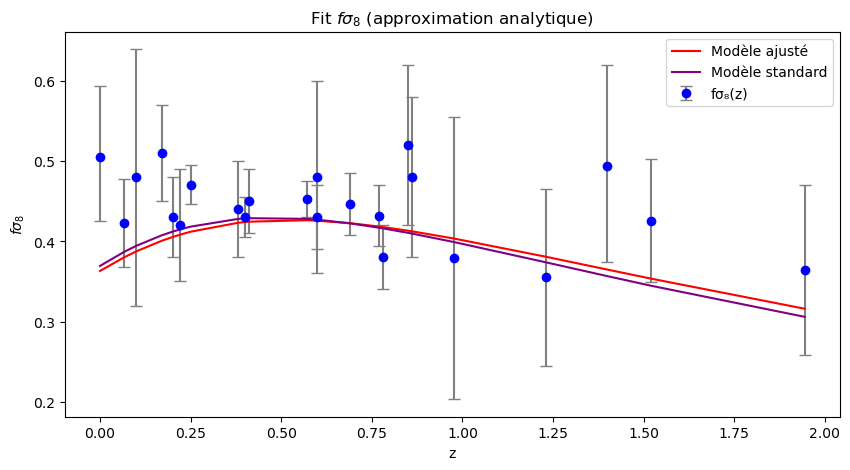

In [ ]:
omega_m0_fit = minimizer.values["omega_m0"]
sigma8_0_fit = minimizer.values["sigma8_0"]
w_fit = minimizer.values["w"]

om_ms = 0.334
S8_ms = 0.81
sig8_ms = S8_ms*(0.3/om_ms)**(0.5)
gamma_fit = library.gamma(omega_m0_fit,w_fit,z_data)
modele = library.omega_mGamma(z_data, gamma_fit, omega_m0_fit,w_fit) * np.array(library.sigma8(sigma8_0_fit, omega_m0_fit, z_data,w_fit))
gamma_modele_standard = library.gamma(om_ms, -1,z_data)
modele_standard = library.omega_mGamma(z_data, gamma_modele_standard, 0.334,-1) * np.array(library.sigma8(sig8_ms,om_ms,z_data,-1))

# --- Plot 1 : Fit et données ---
plt.figure(figsize=(10, 5))
plt.errorbar(z_data, fsig8, yerr=[fsig8_err_minus, fsig8_err_plus], fmt='o', ecolor='gray', elinewidth=1.5, capsize=4, label="fσ₈(z)", color='blue')
plt.plot(z_data, modele, 'r-', label='Modèle ajusté')
plt.plot(z_data, modele_standard, color='purple', linestyle='-', label='Modèle standard')
plt.xlabel('z')
plt.ylabel(r'$f\sigma_8$')
plt.title('Fit $f\sigma_8$ (approximation analytique)')
plt.legend()
plt.grid(True)

In [24]:
import matplotlib as plt

# Niveaux Δχ² pour 2 paramètres libres (pour 68.3%, 95.4%, 99.7%)
levels = [2.30, 6.18, 11.83]

def search_chi2_min_idx(X,Y,Z):
    
    chi2_min = np.min(Z)
    ix_min, iy_min = np.unravel_index(np.argmin(Z), Z.shape)
    x_min = X[ix_min]
    y_min = Y[iy_min]
    
    return chi2_min,x_min,y_min,ix_min,iy_min
    
def plot_contour(X, Y, Z, xlabel, ylabel, title):
    
    chi2_min,x_min,y_min,ix,iy =  search_chi2_min_idx(X,Y,Z)
    delta_chi2 = Z - chi2_min
    Z_clipped = np.clip(delta_chi2, 0, 12)
    print(chi2_min,x_min,y_min)
    cmap = plt.cm.inferno  # ou viridis, plasma, turbo
    levels_fill = np.linspace(0, 12, 100)
    contourf = plt.contourf(X, Y, Z_clipped.T, levels=levels_fill, cmap=cmap)

    contours = plt.contour(X, Y, Z_clipped.T, levels=levels,colors=['white', 'green', 'red'], linewidths=1.0)

    # Minimum chi²
    
    plt.plot(x_min, y_min,'o',color="red",label="min $\chi^2$")
    plt.axvline(x_min, color='red', linestyle='--', alpha=0.5)
    plt.axhline(y_min, color='red', linestyle='--', alpha=0.5)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(False)


    cbar = plt.colorbar(contourf)
    cbar.set_label(r"$\Delta\chi^2$", fontsize=12)

def create_profil(X,Y,Z,x_min,y_min):
    
    chi2_min,x_min,y_min,ix_min,iy_min =  search_chi2_min_idx(X,Y,Z)

    chi2_profil = np.array([])
    
    for i in range(len(Y)):
        chi2_profil = np.append(chi2_profil,Z[ix_min,i])
        
    return Y,chi2_profil
        
        
    
def plot_Chi2_w(X,Y,Z,xlabel,ylabel):
    
    chi2_min,x_min,y_min,ix,iy =  search_chi2_min_idx(X,Y,Z)
    delta_chi2 = Z - chi2_min
    Z_clipped = np.clip(delta_chi2, 0, 12)
    Y,chi2_profil = create_profil(X,Y,Z,x_min,y_min)
    
    plt.plot(Y,chi2_profil,)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axvline(y_min,color='green', linestyle='--', alpha=0.5)
    plt.axhline(chi2_min,color='green', linestyle='--', alpha=0.5)

<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_15924\2167424747.py:29: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(x_min, y_min,'o',color="red",label="min $\chi^2$")


1533.0898362340538 0.31313131313131315 0.7818181818181817
1533.0798111373833 0.31313131313131315 -0.9562289562289563
1533.0812737077629 0.7818181818181817 -0.9562289562289563


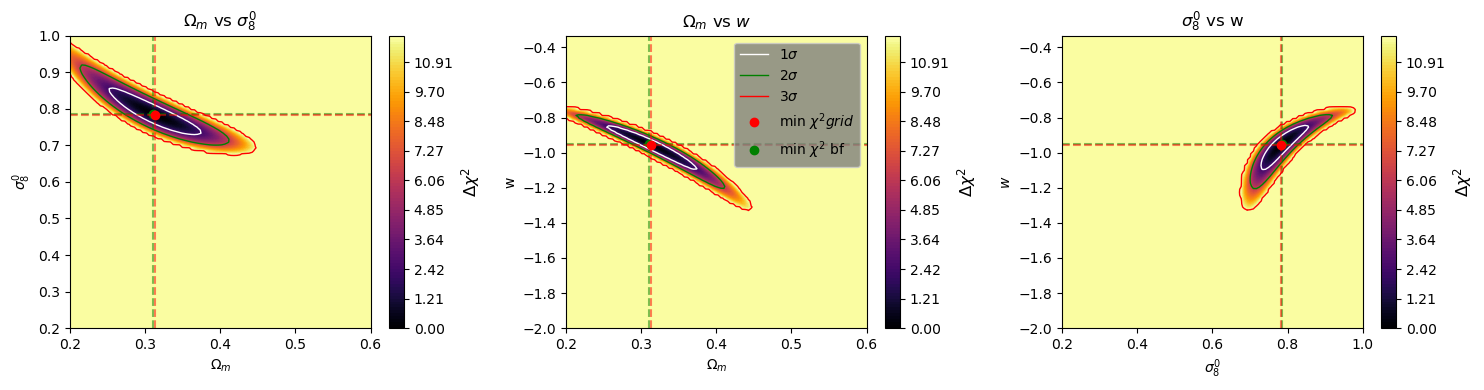

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

# Charger les données
data = np.load("chi2_grids_copy.npz")
omega_m0_vals = data["omega_m0_vals"]
sigma8_0_vals = data["sigma8_0_vals"]
w_vals = data["w_vals"]

chi2_grid_om_sig8 = data["chi2_grid_om_sig8"]
chi2_grid_om_w = data["chi2_grid_om_w"]
chi2_grid_sig8_w = data["chi2_grid_sig8_w"]

plt.figure(figsize=(15, 4))

sigma_labels = [r'1$\sigma$', r'2$\sigma$', r'3$\sigma$', r'min $\chi^2 grid$',r'min $\chi^2$ bf']

# Plan (omega_m0, sigma8_0)
plt.subplot(1, 3, 1)
plt.plot(omega_m0_fit, sigma8_0_fit, 'o', color="green", label='Best-fit')
plt.axvline(omega_m0_fit, color='green', linestyle='--', alpha=0.5)
plt.axhline(sigma8_0_fit, color='green', linestyle='--', alpha=0.5)

plot_contour(omega_m0_vals, sigma8_0_vals, chi2_grid_om_sig8, r"$\Omega_m$", r"$\sigma_{8}^{0}$", r"$\Omega_m$ vs $\sigma_{8}^{0}$")

# Plan (omega_m0, w)
plt.subplot(1, 3, 2)

custom_lines = [
    Line2D([0], [0], color='white', lw=1),
    Line2D([0], [0], color='green', lw=1),
    Line2D([0], [0], color='red', lw=1),
    Line2D([0], [0], color='red', marker='o', lw=0),
    Line2D([0], [0], color='green', marker='o', lw=0)
]

plt.plot(omega_m0_fit, w_fit, 'o', color="green")
plt.axvline(omega_m0_fit, color='green', linestyle='--', alpha=0.5)
plt.axhline(w_fit, color='green', linestyle='--', alpha=0.5)
legend = plt.legend(custom_lines, sigma_labels, loc='upper right', frameon=True)
legend.get_frame().set_facecolor('grey')  
plot_contour(omega_m0_vals, w_vals, chi2_grid_om_w, r"$\Omega_m$", r"w", r"$\Omega_m$ vs $w$")


# Plan (sigma8_0, w)
plt.subplot(1, 3, 3)
plt.plot(sigma8_0_fit, w_fit,'o',color="green", label='Best-fit')
plt.axvline(sigma8_0_fit, color='green', linestyle='--', alpha=0.5)
plt.axhline(w_fit, color='green', linestyle='--', alpha=0.5)
plot_contour(sigma8_0_vals, w_vals, chi2_grid_sig8_w,r"$\sigma_{8}^{0}$",r"$w$", r"$\sigma_{8}^{0}$ vs w")

plt.tight_layout()
plt.show()